In [1]:
import numpy as np
import pandas as pd
import wave
import librosa
from python_speech_features import *

prefix = '/Users/linlin/Desktop/depression'

train_split_df = pd.read_csv(prefix+'train_split_Depression_AVEC2017 (1).csv')
test_split_df = pd.read_csv(prefix+'dev_split_Depression_AVEC2017.csv')
train_split_num = train_split_df[['Participant_ID']]['Participant_ID'].tolist()
test_split_num = test_split_df[['Participant_ID']]['Participant_ID'].tolist()
# train_split_clabel = train_split_df[['PHQ8_Binary']]['PHQ8_Binary'].tolist()
# test_split_clabel = test_split_df[['PHQ8_Binary']]['PHQ8_Binary'].tolist()
train_split_clabel = train_split_df[['PHQ8_Score']]['PHQ8_Score'].tolist()
test_split_clabel = test_split_df[['PHQ8_Score']]['PHQ8_Score'].tolist()

def get_mfcc(signal, sr):
    wav_feature = mfcc(signal, samplerate=sr, winlen=10, winstep=5, winfunc=np.hamming, nfft=160000)
    d_mfcc_feat = delta(wav_feature, 2)
    d_mfcc_feat2 = delta(wav_feature, 2)
    feature = np.hstack((wav_feature, d_mfcc_feat, d_mfcc_feat2))
    return feature

def get_spec(signal, sr):
    winlen = 1.2
    winstep = 0.3
    clip = int(sr*winlen)
    shift = int(sr*winstep)
    
    window = np.hanning(sr*winlen)
    
#     framing
    frames = []
    frame_num = 0
    start = 0
    while start < len(signal):
        if start+clip < len(signal):
            frames.append(signal[start:start+clip])
        else:
            frames.append(np.hstack((signal[start:], np.zeros(clip-len(signal[start:])))))
        start += shift
        
    frames = window * frames
    return sigproc.logpowspec(frames, NFFT=32000)[:, :400]

# def extract_features(number, audio_features, target, audio_targets, mode):
#     transcript = pd.read_csv(prefix+'{0}_P/{0}_TRANSCRIPT.csv'.format(number), sep='\t').fillna('')
    
#     wavefile = wave.open(prefix+'{0}_P/{0}_AUDIO.wav'.format(number, 'r'))
#     sr = wavefile.getframerate()
#     nframes = wavefile.getnframes()
#     wave_data = np.frombuffer(wavefile.readframes(nframes), dtype=np.short)
    
#     time_range = []
#     response = ''
#     response_flag = False
#     time_collect_flag = False
#     start_time = 0
#     stop_time = 0

#     signal = []
    
#     global counter_train, counter_test, debt

#     for t in transcript.itertuples():
#         # participant一句话结束
#         if getattr(t,'speaker') == 'Ellie':
#             continue
#         elif getattr(t,'speaker') == 'Participant':
#             if 'scrubbed_entry' in getattr(t,'value'):
#                 continue
#             start_time = int(getattr(t,'start_time')*sr)
#             stop_time = int(getattr(t,'stop_time')*sr)
#             signal = np.hstack((signal, wave_data[start_time:stop_time].astype(np.float)))
        
#     clip = sr*60
#     shift = sr*30*1 if mode == 'train' else int(sr*30*1.6)
#     start = 0
#     signal = np.array(signal)
#     counter = 0
#     if mode == 'test':
#         if target == 1:
#             while start+clip < len(signal):
#                 feature = get_spec(signal[start:start+clip],sr=sr)
#                 audio_features.append(feature)
#                 audio_targets.append(target)
#                 start+=shift
#         else:
#             times = 10+debt if counter_test < 80 else 9+debt
#             for i in range(times):
#                 if start+clip > len(signal):
#                     debt+=1
#                 else:   
#                     feature = get_spec(signal[start:start+clip],sr=sr)
#                     audio_features.append(feature)
#                     audio_targets.append(target)
#                     start+=shift
#                     counter_test+=1
#                     if debt > 0:
#                         debt -= 1
#     else:
#         if target == 1:
#             while start+clip < len(signal):
#                 feature = get_spec(signal[start:start+clip],sr=sr)
#                 audio_features.append(feature)
#                 audio_targets.append(target)
#                 start+=shift
#         else:
#             times = 6+debt
#             for i in range(times):
#                 if start+clip > len(signal):
#                     debt+=1
#                 else:
#                     feature = get_spec(signal[start:start+clip],sr=sr)
#                     audio_features.append(feature)
#                     audio_targets.append(target)
#                     start+=shift
#                     counter_train+=1
#                     if debt > 0:
#                         debt -= 1
#                 counter+=1
#             mark_test.append(counter)
#     print(np.shape(audio_features))
#     print('{}_P feature done'.format(number))

def extract_features(number, audio_features, target, audio_targets, mode):
    transcript = pd.read_csv(prefix+'{0}_P/{0}_TRANSCRIPT.csv'.format(number), sep='\t').fillna('')
    
    wavefile = wave.open(prefix+'{0}_P/{0}_AUDIO.wav'.format(number, 'r'))
    sr = wavefile.getframerate()
    nframes = wavefile.getnframes()
    wave_data = np.frombuffer(wavefile.readframes(nframes), dtype=np.short)
    
    time_range = []
    response = ''
    response_flag = False
    time_collect_flag = False
    start_time = 0
    stop_time = 0

    signal = []
    
    global counter_train

    for t in transcript.itertuples():
        # participant一句话结束
        if getattr(t,'speaker') == 'Ellie':
            continue
        elif getattr(t,'speaker') == 'Participant':
            if 'scrubbed_entry' in getattr(t,'value'):
                continue
            start_time = int(getattr(t,'start_time')*sr)
            stop_time = int(getattr(t,'stop_time')*sr)
            signal = np.hstack((signal, wave_data[start_time:stop_time].astype(np.float)))
        
    # 1分钟
    clip = sr*1*15
    if target >= 10 and mode == 'train':
        times = 3 if counter_train < 48 else 2
        for i in range(times):
            if clip*(i+1) > len(signal):
                continue
            melspec = librosa.feature.melspectrogram(signal[clip*i:clip*(i+1)], n_mels=80,sr=sr)
#             melspec = base.logfbank(signal[clip*i:clip*(i+1)], samplerate=sr, winlen=0.064, winstep=0.032, nfilt=80, nfft=1024, lowfreq=130, highfreq=6854)
            logspec = melspec 
            audio_features.append(logspec)
            audio_targets.append(target)
            counter_train+=1
    else:  
        melspec = librosa.feature.melspectrogram(signal[:clip], n_mels=80, sr=sr)
#         melspec = base.logfbank(signal[:clip], samplerate=sr, winlen=0.064, winstep=0.032, nfilt=80, nfft=1024, lowfreq=130, highfreq=6854)
        logspec = melspec 
        audio_features.append(logspec) 
        audio_targets.append(target)
#     print(melspec.shape)
    print('{}_P feature done'.format(number))
    
# training set
audio_features_train = []
audio_ctargets_train = []

# test set
audio_features_test = []
audio_ctargets_test = []
mark_test = []

counter_train = 0
counter_test = 0
debt = 0

# # training set
# for index in range(len(train_split_num)):
#     extract_features(train_split_num[index], audio_features_train, train_split_clabel[index], audio_ctargets_train, 'train')

# debt=0
# # test set
# for index in range(len(test_split_num)):
#     extract_features(test_split_num[index], audio_features_test, test_split_clabel[index], audio_ctargets_test, 'test')

# print(np.shape(audio_ctargets_train), np.shape(audio_ctargets_test))
# print(counter_train, counter_test)

# print("Saving npz file locally...")
# np.savez(prefix+'data/audio/train_samples_reg.npz', audio_features_train)
# np.savez(prefix+'data/audio/train_labels_reg.npz', audio_ctargets_train)
# np.savez(prefix+'data/audio/test_samples_reg.npz', audio_features_test)
# np.savez(prefix+'data/audio/test_labels_reg.npz', audio_ctargets_test)



In [ ]:
import torch 
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.nn import functional as F

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [3]:
n_classes = 1
    
class concat_cnn(nn.Module):
    def __init__(self, n_classes):
        super(concat_cnn, self).__init__()
        self.n_classes = n_classes
#         time
        self.conv1b = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(2,8), stride=1, padding=(0,4))
#         freq
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(10,2), stride=1, padding=(4,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=1)  
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=1)  
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=1)  
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=80, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=1)  
        )
        self.top_down = nn.Conv2d(in_channels=80, out_channels=n_classes, kernel_size=(1,1), stride=1, padding=1)
        self.bottom_up = nn.Conv2d(in_channels=80, out_channels=1, kernel_size=(1,1), stride=1, padding=1)
        
    def forward(self, x):
        x1 = self.conv1b(x)
        x2 = self.conv1a(x)
        x = torch.cat((x1, x2), 1)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        top_down = self.top_down(x)
        bottom_up = self.bottom_up(x)
        x = top_down.mul(bottom_up)
        output = torch.mean(torch.mean(x, dim=-1), dim=-1)
        return output
    
class oned_cnn(nn.Module):
    def __init__(self, n_classes, embed_size):
        super(oned_cnn, self).__init__()
        self.n_classes = n_classes
        self.embed_size = embed_size
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, (self.embed_size), 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, (3, 3), 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(64, 64, (3, 1), 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 64, (3, 3), 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))  
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.n_classes),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.dropout(x)
        
        x = F.adaptive_max_pool2d(x, (1, 1))
        return self.fc(x)
        

In [4]:

config = {
    'num_classes': 1,
    'dropout': 0.5,
    'rnn_layers': 2,
    'embedding_size': 80,
    'batch_size': 2,
    'epochs': 30,
    'learning_rate': 1e-4,
    'hidden_dims': 64,
    'cuda': False,
    'kernel_width': 75,
}

X_train = np.array(audio_features_train)
Y_train = np.array(audio_ctargets_train)
X_test = np.array(audio_features_test)
Y_test = np.array(audio_ctargets_test)

# Note: We use a very simple setting here (assuming all levels have the same # of channels.
# model = CNN()
# model = concat_cnn(config['num_classes'])
model = oned_cnn(config['num_classes'], config['embedding_size'])

if config['cuda']:
    model = model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def save(model, filename):
    save_filename = '{}.pt'.format(filename)
    torch.save(model, save_filename)
    print('Saved as %s' % save_filename)
    
def standard_confusion_matrix(y_test, y_test_pred):
    """
    Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_test, y_test_pred)
    return np.array([[tp, fp], [fn, tn]])

def model_performance(y_test, y_test_pred_proba):
    """
    Evaluation metrics for network performance.
    """
#     y_test_pred = y_test_pred_proba.data.max(1, keepdim=True)[1]
    y_test_pred = y_test_pred_proba

    # Computing confusion matrix for test dataset
    conf_matrix = standard_confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    return y_test_pred, conf_matrix

def plot_roc_curve(y_test, y_score):
    """
    Plots ROC curve for final trained model. Code taken from:
    https://vkolachalama.blogspot.com/2016/05/keras-implementation-of-mlp-neural.html
    """
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.savefig(prefix+'images/BiLSTM_roc.png')
    plt.close()


def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    correct = 0
    for i in range(0, X_train.shape[0], config['batch_size']):
        if i + config['batch_size'] > X_train.shape[0]:
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+config['batch_size'])], Y_train[i:(i+config['batch_size'])]
        if config['cuda']:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True).cuda(), Variable(torch.from_numpy(y)).cuda()
        else:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True), Variable(torch.from_numpy(y))
        # 将模型的参数梯度设置为0
        optimizer.zero_grad()
        output = model(x.unsqueeze(1))
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(y.data.view_as(pred)).cpu().sum()
        loss = criterion(output, y)
        # 后向传播调整参数
        loss.backward()
        # 根据梯度更新网络参数
        optimizer.step()
        batch_idx += 1
        # loss.item()能够得到张量中的元素值
        total_loss += loss.item()

    cur_loss = total_loss
    print('Train Epoch: {:2d}\t Learning rate: {:.4f}\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)\n '.format(
                epoch, config['learning_rate'], cur_loss/len(X_train), correct, len(X_train),
        100. * correct / len(X_train)))


def evaluate():
    model.eval()
    batch_idx = 1
    total_loss = 0
    pred = torch.empty(config['batch_size'], 1).type(torch.LongTensor)
    for i in range(0, X_test.shape[0], config['batch_size']):
        if i + config['batch_size'] > X_test.shape[0]:
            x, y = X_test[i:], Y_test[i:]
        else:
            x, y = X_test[i:(i+config['batch_size'])], Y_test[i:(i+config['batch_size'])]
        if config['cuda']:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True).cuda(), Variable(torch.from_numpy(y)).cuda()
        else:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True), Variable(torch.from_numpy(y))
        with torch.no_grad():
            output = model(x.unsqueeze(1))
        loss = criterion(output, y)
#         print(pred.size(), output.data.max(1, keepdim=True)[1].size(), output.data.max(1, keepdim=True)[1])
        pred = torch.cat((pred, output.data.max(1, keepdim=True)[1]))
        total_loss += loss.item()
        
    Y_pred = []
    for i, mark in enumerate(mark_test):
        print()
        if torch.sum(pred[np.sum(mark_test[:i]): np.sum(mark_test[:i])+i]).data() > mark/2:
            Y_pred.append(1)
        else:
            Y_pred.append(0)
    y_test_pred, conf_matrix = model_performance(Y_test, Y_pred)
    print('\nTest set: Average loss: {:.4f}'.format(total_loss/len(X_test)))

    # custom evaluation metrics
    print('Calculating additional test metrics...')
    accuracy = float(conf_matrix[0][0] + conf_matrix[1][1]) / np.sum(conf_matrix)
    precision = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])
    recall = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[1][0])
    f1_score = 2 * (precision * recall) / (precision + recall)
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1-Score: {}\n".format(f1_score))
    print('='*89)
    

    return total_loss


In [5]:
for ep in range(1, config['epochs']):
    train(ep)
    tloss = evaluate()

ZeroDivisionError: division by zero

In [5]:
# 读取keras模型的权重
import keras
import h5py
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error


# # 模型地址
# MODEL_PATH = '/Users/apple/Downloads/cnn_melspec_test.h5'

# # 获取每一层的连接权重及偏重
# print("读取模型中...")
# with h5py.File(MODEL_PATH, 'r') as f:
#     conv2d_1 = f['/model_weights/conv2d_1/conv2d_1']
#     conv2d_1_bias =  conv2d_1['bias:0'][:]
#     conv2d_1_kernel = conv2d_1['kernel:0'][:]
    
#     conv2d_2 = f['/model_weights/conv2d_2/conv2d_2']
#     conv2d_2_bias =  conv2d_2['bias:0'][:]
#     conv2d_2_kernel = conv2d_2['kernel:0'][:]
    
#     dense_1 = f['/model_weights/dense_1/dense_1']
#     dense_1_bias =  dense_1['bias:0'][:]
#     dense_1_kernel = dense_1['kernel:0'][:]

#     dense_2 = f['/model_weights/dense_2/dense_2']
#     dense_2_bias = dense_2['bias:0'][:]
#     dense_2_kernel = dense_2['kernel:0'][:]

#     dense_3 = f['/model_weights/dense_3/dense_3']
#     dense_3_bias = dense_3['bias:0'][:]
#     dense_3_kernel = dense_3['kernel:0'][:]
    
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv2d_1 = nn.Conv2d(1, 32, (1,7), 1)
        self.conv2d_2 = nn.Conv2d(32, 32, (1,7), 2)
        self.dense_1 = nn.Linear(29952, 128)
        self.dense_2 = nn.Linear(128, 128)
        self.dense_3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv2d_1(x))
        x = F.max_pool2d(x, (4, 3), (1, 3))
        x = F.relu(self.conv2d_2(x))
        x = F.max_pool2d(x, (1, 3), (1, 3))
#         flatten in keras
        x = x.permute((0, 2, 3, 1))
        x = x.contiguous().view(-1, 29952)
        x = F.relu(self.dense_1(x))
#         x = F.relu(self.dense_2(x))
        x = self.dense_2(x)
        x = self.dropout(x)
        # output = torch.sigmoid(self.dense_3(x))
        output = torch.relu(self.dense_3(x))
        return output

def keras_to_pyt(km, pm):
    weight_dict = dict()
    for layer in km.layers:
        if type(layer) is keras.layers.convolutional.Conv2D:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (3, 2, 0, 1))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
        elif type(layer) is keras.layers.Dense:
            weight_dict[layer.get_config()['name'] + '.weight'] = np.transpose(layer.get_weights()[0], (1, 0))
            weight_dict[layer.get_config()['name'] + '.bias'] = layer.get_weights()[1]
    pyt_state_dict = pm.state_dict()
    for key in pyt_state_dict.keys():
        pyt_state_dict[key] = torch.from_numpy(weight_dict[key])
    pm.load_state_dict(pyt_state_dict)
    return pm

In [6]:
# pytorch: out_channel, in_channel, kernel_height, kernel_width
# keras: kernel_height, kernel_width, out_channel, in_channel
keras_model = load_model('/Users/apple/Downloads/depression/cnn_melspec_reg_4.25.h5')
pyt_model = keras_to_pyt(keras_model, CNN())

In [7]:
features_train = np.load(prefix+'data/audio/train_samples_reg.npz', allow_pickle=True)['arr_0']
features_test = np.load(prefix+'data/audio/test_samples_reg.npz', allow_pickle=True)['arr_0']
targets_train = np.load(prefix+'data/audio/train_labels_reg.npz', allow_pickle=True)['arr_0']
ctargets_test = np.load(prefix+'data/audio/test_labels_reg.npz', allow_pickle=True)['arr_0']

X_train = np.array(features_train)
X_test = np.array(features_test)
Y_train = np.array(targets_train)
Y_test = np.array(ctargets_test)

# preprocess
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = np.array([(X - X.min()) / (X.max() - X.min()) for X in X_train])
X_test = np.array([(X - X.min()) / (X.max() - X.min()) for X in X_test])

batch_size = 1

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

def keras_img_prep(X, img_rows, img_cols):
    """
    Reshape feature matrices for Keras' expexcted input dimensions.
    For 'th' (Theano) dim_order, the model expects dimensions:
    (# channels, # images, # rows, # cols).
    """
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    return X

def evaluate(model):
    model.eval()
    batch_idx = 1
    total_loss = 0
#     pred = torch.empty(batch_size, 1).type(torch.LongTensor)
    pred = np.array([])
    print("!")
    for i in range(0, X_test.shape[0], batch_size):
        if i + batch_size > X_test.shape[0]:
            x, y = X_test[i:], Y_test[i:]
        else:
            x, y = X_test[i:(i+batch_size)], Y_test[i:(i+batch_size)]
        if False:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True).cuda(), Variable(torch.from_numpy(y)).cuda()
        else:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True), Variable(torch.from_numpy(y).type(torch.FloatTensor))
        with torch.no_grad():
            output = model(x.unsqueeze(1))
        loss = criterion(output, torch.tensor(y))
#         pred = torch.cat((pred, output.data.max(1, keepdim=True)[1]))
        pred = np.hstack((pred, output.flatten().numpy()))
        total_loss += loss.item()
    
#     y_test_pred, conf_matrix = model_performance(Y_test, pred[2:])

    # custom evaluation metrics
#     print('Calculating additional test metrics...')
#     accuracy = float(conf_matrix[0][0] + conf_matrix[1][1]) / np.sum(conf_matrix)
#     precision = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])
#     recall = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[1][0])
#     f1_score = 2 * (precision * recall) / (precision + recall)
#     print("Accuracy: {}".format(accuracy))
#     print("Precision: {}".format(precision))
#     print("Recall: {}".format(recall))
#     print("F1-Score: {}\n".format(f1_score))
    print(Y_test, pred)
    print('MAE: {}'.format(mean_absolute_error(Y_test, pred)))
    print('='*89)

    return total_loss

In [8]:
evaluate(pyt_model)

!


/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/apple/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[ 4  4  8 12 23 19 16 16  0 17 14  9  7  0  0  2 10  7 10  3 12  0  1 19
  4  5  3  3  2  1 15  9  3  2  0] [ 5.83920956  2.37882519 11.52943516  7.84931374  9.05646706  4.19742775
 10.69526196 14.31465816  3.80322433 12.76362228  9.83319378  7.3277669
  5.46524     1.05751717  5.51554012  3.67049432  4.08851957  5.6579361
  7.51830387  9.7425766   9.89487553  3.25716829  2.4081459   8.66451645
 10.53070927  0.89661759  3.4621222   2.7933259   5.04265261  5.98749971
  7.0635314   3.99010372 11.18947506  3.08699512  3.05345559]
MAE: 4.249334687846048


1041.2204981930554

In [9]:
inp_keras = keras_img_prep(X_test, 80, 469)
keras_res = keras_model.predict(x=inp_keras, verbose=1)
# model_performance(Y_test, keras_res)
mean_absolute_error(Y_test, keras_res), np.sqrt(mean_squared_error(Y_test, keras_res))

35/35 [==============================] - 3s 97ms/step


(4.24933488539287, 5.454278992503261)

In [152]:
torch.save(pyt_model.state_dict(), 'cnn_melspec.pt')

(80, 469)


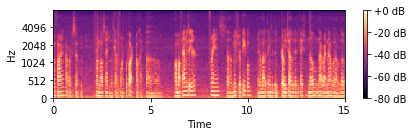

In [20]:
# plt.figure(figsize=(6, 2))
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time')

# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()
# plt.savefig('spec.png', dpi=600,format='png')
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
from librosa import display
import pandas as pd
import wave
import numpy as np
import librosa

prefix = '/Users/linlin/Desktop/depression/'

number=302
transcript = pd.read_csv(prefix+'{0}_P/{0}_TRANSCRIPT.csv'.format(number), sep='\t').fillna('')
    
wavefile = wave.open(prefix+'{0}_P/{0}_AUDIO.wav'.format(number, 'r'))
sr = wavefile.getframerate()
nframes = wavefile.getnframes()
wave_data = np.frombuffer(wavefile.readframes(nframes), dtype=np.short)
    
time_range = []
response = ''
response_flag = False
time_collect_flag = False
start_time = 0
stop_time = 0

signal = []
    
global counter_train

for t in transcript.itertuples():
        # participant一句话结束
    if getattr(t,'speaker') == 'Ellie':
        continue
    elif getattr(t,'speaker') == 'Participant':
        if 'scrubbed_entry' in getattr(t,'value'):
            continue
        start_time = int(getattr(t,'start_time')*sr)
        stop_time = int(getattr(t,'stop_time')*sr)
        signal = np.hstack((signal, wave_data[start_time:stop_time].astype(np.float)))

#  ==================== melspec ========================

plt.figure(figsize=(15, 2))
S = librosa.feature.melspectrogram(y=signal[:15*sr], sr=sr, n_mels=80, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)

plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig('melspec.eps', dpi=600,format='eps')
plt.show()

#  ==================== melspec ========================

#  ==================== spec ========================

D = np.abs(librosa.stft(signal[:sr*18]))

plt.figure(figsize=(15, 2))

librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), y_axis='log', x_axis='time', fmax=8000)

plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.savefig('spec.eps',dpi=600,format='eps')
plt.show()

#  ==================== spec ========================

#  ==================== wave ========================
librosa.display.waveplot(signal[:15*sr], sr=sr)
plt.savefig('wave.png',dpi=600,format='png')
plt.show

#  ==================== wave ========================


In [7]:
from scipy import signal
kernel = np.random.randn(1, 7)
conv1 = signal.convolve2d(S_dB, kernel, 'valid')

plt.figure(figsize=(6, 3))
display.specshow(conv1, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

NameError: name 'S_dB' is not defined

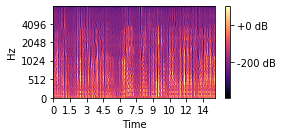

In [29]:
kernel = np.random.randn(1, 7)
conv2 = signal.convolve2d(conv1, kernel, 'valid')

plt.figure(figsize=(4, 2))
display.specshow(conv2, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [29]:
def evaluate(model, X_test, Y_test):
    model.eval()
    batch_idx = 1
    total_loss = 0
    batch_size = 2
    pred = np.array([])
    global y_test_pred, y_test_pred_proba
    for i in range(0, X_test.shape[0], batch_size):
        if i + batch_size > X_test.shape[0]:
            x, y = X_test[i:], Y_test[i:]
        else:
            x, y = X_test[i:(i+batch_size)], Y_test[i:(i+batch_size)]
        if False:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True).cuda(), Variable(torch.from_numpy(y)).cuda()
        else:
            x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True), torch.from_numpy(y).type(torch.FloatTensor)
        with torch.no_grad():
            output = model(x.unsqueeze(1))
        # indices = torch.nonzero(output < 1e-8)
        # for i in indices:
        #     output[i[0], i[1]] = 0
        # print('pytorch: {}\t{} \n keras: {}\t{} \n target: {} \n'.format(output, np.argmax(output.numpy(), axis=1), \
        #      y_test_pred_proba[(batch_idx-1)*batch_size:batch_idx*batch_size], y_test_pred[(batch_idx-1)*batch_size:batch_idx*batch_size], y))
        # loss = nn.CrossEntropyLoss()(output, y[:, 1].type(torch.LongTensor))
        
        # pred = np.hstack((pred, np.argmax(output.numpy(), axis=1)))
        pred = np.hstack((pred, output.flatten().numpy()))
        # total_loss += loss.item()
        batch_idx+=1
    
    mae = mean_absolute_error(pred, Y_test)
    print("mae: {}".format(mae))

cnn_model = CNN()
cnn_model.load_state_dict(torch.load('/Users/apple/Downloads/depression/cnn_melspec_reg.pt'))
evaluate(cnn_model, X_test, Y_test)


mae: 18393591085.30719
